In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import pandas as pd
from pandas import Series
import os
from collections import defaultdict

#----------- sklearn ------------------------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
#----------- keras ------------------------------
from keras.preprocessing.text import Tokenizer
#----------- gensim ------------------------------
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#----------- NLTK ------------------------------
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords



In [2]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 400)

In [3]:
path = 'D:\Whats-Cooking/'
os.chdir(path)

In [4]:
train_row_df = pd.read_json('data/train.json')
test_row_df = pd.read_json('data/test.json')

In [5]:
train_row_df.shape

(39774, 3)

In [6]:
test_row_df.shape

(9944, 2)

In [7]:
train_row_df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam masala, double cream, natural yogurt, bay leaf]"
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, warm water, large eggs, all-purpose flour, whole wheat flour, cooking spray, boiling water, steel-cut oats, dry yeast, salt]"
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, broccoli florets, rotini, pitted black olives, Kraft Grated Parmesan Cheese, red pepper]"
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starter, flour, hot tea, sugar, ground nutmeg, salt, ground cinnamon, milk, butter]"
39772,41882,chinese,"[boneless chicken skinless thigh, minced garlic, steamed white rice, baking powder, corn starch, dark soy sauce, kosher salt, peanuts, flour, scallions, Chinese rice vinegar, vodka, fresh ginger, egg whites, broccoli, toasted sesame seeds, sugar, store bought low sodium chicken stock, baking soda, Shaoxing wine, oil]"


In [8]:
test_row_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisins, milk, white sugar]"
1,28583,"[sugar, egg yolks, corn starch, cream of tartar, bananas, vanilla wafers, milk, vanilla extract, toasted pecans, egg whites, light rum]"
2,41580,"[sausage links, fennel bulb, fronds, olive oil, cuban peppers, onions]"
3,29752,"[meat cuts, file powder, smoked sausage, okra, shrimp, andouille sausage, water, paprika, hot sauce, garlic cloves, browning, lump crab meat, vegetable oil, all-purpose flour, freshly ground pepper, flat leaf parsley, boneless chicken skinless thigh, dried thyme, white rice, yellow onion, ham]"
4,35687,"[ground black pepper, salt, sausage casings, leeks, parmigiano reggiano cheese, cornmeal, water, extra-virgin olive oil]"


<AxesSubplot:xlabel='cuisine'>

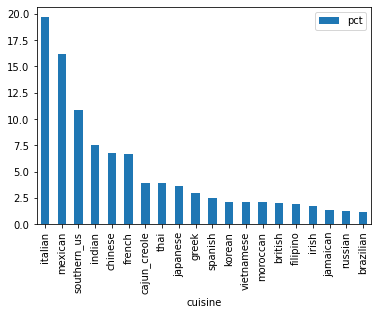

In [9]:
train_row_df.groupby('cuisine')\
            .agg(
                count = ('ingredients', 'count')
            )\
            .sort_values(by = ['count'],ascending= False)\
            .assign(
                total_cnt = lambda x : x['count'].sum()\
                ,pct = lambda x : (x['count'] / x['total_cnt']) * 100  
            )\
            .reset_index()\
            .plot.bar(x='cuisine', y='pct')

Text(0.5, 1.0, 'Most common ingredients')

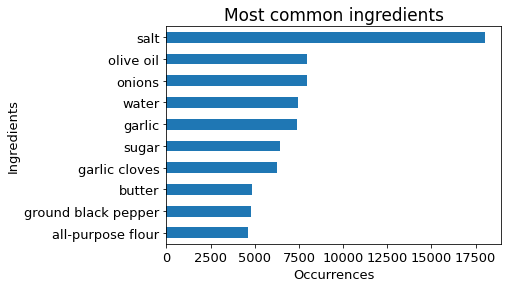

In [11]:
def get_ingredients(data):
    """This function gets a dataframe o series of lists and returns all the
    ingredients that appear in the object - NOT UNIQUE ingredients"""
    all_ingredients = []
    for i in range(len(data)):
        if isinstance(data, pd.core.frame.DataFrame):
            all_ingredients.extend(data.loc[i, 'ingredients'])
        else:
            all_ingredients.extend(data.iloc[i])
    return Series(all_ingredients)



all_ingredients = get_ingredients(train_row_df["ingredients"])
ax = all_ingredients.value_counts()[:10].sort_values(ascending=True).plot(kind='barh', fontsize=13)
ax.set_xlabel('Occurrences', fontsize=13)
ax.set_ylabel('Ingredients', fontsize=13)
ax.set_title('Most common ingredients', fontsize=17)

In [10]:
class text_preprocessing(TransformerMixin):
    
    def __init__(self, concat_ingredients = False):
        self.concat_ingredients = concat_ingredients
        
    def transform(self, ingredients):
        BAD_SYMBOLS_RE = re.compile('[^0-9a-z]')
        STOPWORDS = set(stopwords.words('english'))

        if(self.concat_ingredients):
            ingredients = ingredients.apply(lambda ing_list: [ingredient.replace(' ','') for ingredient in ing_list]) # concat multi word ingredient 

        ingredients = ingredients.apply(lambda ing_list: ' '.join(ing_list)) # convert list of ingredients to string
        ingredients = ingredients.str.lower() # ingredients string to lower case letters
        ingredients = ingredients.apply(lambda ing_list: BAD_SYMBOLS_RE.sub(' ', ing_list)) # remove all non(numbers, characters) from the string
        ingredients = ingredients.apply(lambda ing_list: ' '.join([word for word in ing_list.split() if word not in STOPWORDS])) # remove stopwords       
        
        return ingredients
    
    def fit(self, X, Y):
        return self

In [11]:
X , Y = train_row_df['ingredients'], train_row_df['cuisine']

In [12]:
validation_size = 0.3
random_state = 42

In [13]:
x_train, x_vald , y_train , y_vald = train_test_split(X, Y, test_size = validation_size, random_state = random_state)

x_test = test_row_df['ingredients']

In [14]:
pipelines = defaultdict(None)

NB_Pipeline = Pipeline([
               ('pre', text_preprocessing()),
               ('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])
pipelines['Multinomial Naive Bayes'] = NB_Pipeline


SGD_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf' , SGDClassifier())
              ])
pipelines['SGDClassifier'] = SGD_Pipeline


LR_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())
              ])
pipelines['LogisticRegression'] = LR_Pipeline


RF_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())
              ])
pipelines['RandomForestClassifier'] = RF_Pipeline


SVC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC())
              ])
pipelines['SVMClassifier'] = SVC_Pipeline


KNC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())
              ])
pipelines['KNeighborsClassifier'] = KNC_Pipeline

In [15]:
for name, pipeline in pipelines.items():
    print("Training ",name)
    pipeline.fit(x_train,y_train)
    

Training  Multinomial Naive Bayes
Training  SGDClassifier
Training  LogisticRegression
Training  RandomForestClassifier
Training  SVMClassifier
Training  KNeighborsClassifier


In [16]:
best_accuracy=0.0
best_classifier_name = 0

for name,model in pipelines.items():
    score = model.score(x_vald, y_vald)
    if score > best_accuracy:
        best_accuracy = score
        best_classifier_name = name 
        
    print(f'''{name} Test Accuracy: {score}''')
    
    
    pd.DataFrame(
             { 'id' : test_row_df['id'],
               'cuisine': model.predict(x_test)
             }
            )\
  .to_csv("data/"+name+"_Submission.csv", index=False)


print('--------------------------------------------------------')
print(f'''Best Pipeline is {best_classifier_name} with Accuracy {best_accuracy}''')

Multinomial Naive Bayes Test Accuracy: 0.6698231794184195
SGDClassifier Test Accuracy: 0.7731500879912847
LogisticRegression Test Accuracy: 0.7795189809771222
RandomForestClassifier Test Accuracy: 0.7414732255090924
SVMClassifier Test Accuracy: 0.795608815888712
KNeighborsClassifier Test Accuracy: 0.7275622224084471
--------------------------------------------------------
Best Pipeline is SVMClassifier with Accuracy 0.795608815888712


In [17]:
SVC_Pipeline = Pipeline([
                ('pre', text_preprocessing()),
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(
                            C= 10,
                            decision_function_shape= 'ovo',
                            gamma= 'scale',
                            kernel= 'rbf'
                            )) 
              ])

SVC_Pipeline.fit(X , Y )

Pipeline(steps=[('pre',
                 <__main__.text_preprocessing object at 0x0000026A4894F7F0>),
                ('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC(C=10, decision_function_shape='ovo'))])

In [18]:
pd.DataFrame(
             { 'id' : test_row_df['id'],
               'cuisine': SVC_Pipeline.predict(x_test)
             }
            )\
  .to_csv("data/Best_Model_Submission.csv", index=False)

